In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from bayes_opt import BayesianOptimization


In [47]:
df = pd.read_csv('clean_df (1).csv')
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Sdng,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,False,4,0,1,0,0,0,1,0
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,False,4,0,1,0,0,0,1,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,True,False,4,0,1,0,0,0,1,0
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,False,4,0,1,0,0,0,1,0
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,False,4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,False,4,0,1,0,0,0,1,0
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,False,4,0,1,0,0,0,1,0
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,False,True,4,0,1,0,0,0,1,0
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,False,4,0,1,0,0,0,1,0


In [48]:
df['SalePrice_binned'] = pd.qcut(df['SalePrice'], q=5, labels=False)

In [49]:
df['SalePrice_binned'].value_counts()

,count
SalePrice_binned,
0,595
3,593
2,581
1,580
4,578


=> given the built in pd.qcut method, we discretisized the continuous target variable "SalePrice" into 4 classes

The qcut method uses a quantile based approach to discretize a continuous variable

Now, implementing xgboost for a Multi-Class classification, using SalePrice_binned as target variable

In [50]:
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low,SalePrice_binned
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,4,0,1,0,0,0,1,0,3
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,4,0,1,0,0,0,1,0,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,False,4,0,1,0,0,0,1,0,2
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,4,0,1,0,0,0,1,0,4
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,4,0,1,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,4,0,1,0,0,0,1,0,1
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,4,0,1,0,0,0,1,0,1
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,True,4,0,1,0,0,0,1,0,1
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,4,0,1,0,0,0,1,0,2


In [51]:
X = df.drop(columns=['SalePrice', 'SalePrice_binned'])
y = df['SalePrice_binned']

Firstly, implemented without stratification

In [52]:
'''80 test 20 train'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
xgb80_20 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)


In [54]:
xgb80_20.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [55]:
y_pred_80_20 = xgb80_20.predict(X_test)
y_pred_proba_80_20 = xgb80_20.predict_proba(X_test)
y_pred_80_20
y_pred_proba_80_20

array([[0.00668172, 0.00736774, 0.01377393, 0.05817899, 0.9139976 ],
       [0.28747633, 0.48347142, 0.17101167, 0.0320384 , 0.02600219],
       [0.02339986, 0.02651033, 0.36632574, 0.55858946, 0.02517465],
       ...,
       [0.00569842, 0.00628348, 0.00795654, 0.02305246, 0.95700914],
       [0.03600165, 0.04078722, 0.18277706, 0.59247   , 0.14796408],
       [0.18227063, 0.63760614, 0.11206552, 0.03376586, 0.0342919 ]],
      dtype=float32)

In [56]:
# accuracy
acc = accuracy_score(y_test, y_pred_80_20)
print(f"Accuracy: {acc:.4f}")

#  Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_80_20))

# 3. Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_80_20))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.58      0.61      0.59       121
           2       0.55      0.47      0.51       114
           3       0.68      0.73      0.71       120
           4       0.90      0.86      0.88       111

    accuracy                           0.70       586
   macro avg       0.70      0.70      0.70       586
weighted avg       0.69      0.70      0.69       586


Confusion Matrix:
 [[97 18  5  0  0]
 [24 74 19  4  0]
 [ 4 33 54 23  0]
 [ 0  2 19 88 11]
 [ 0  1  1 14 95]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

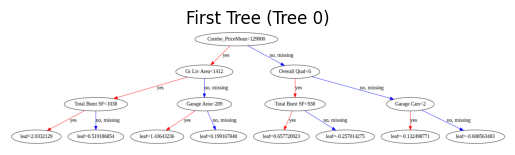

In [57]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb80_20, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()



In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=0, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_tree0", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

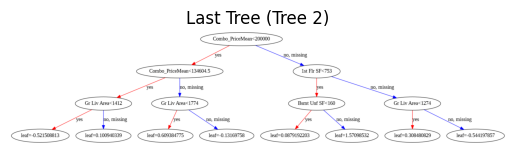

In [58]:
# last tree = index num_estimators - 1
last_tree_idx = xgb80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb80_20, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=last_tree_idx, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_lasttree", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

10 90 train test split without stratification and tree plot + eval

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [60]:
xgb90_10 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)

In [61]:
xgb90_10.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [62]:
y_pred_90_10 = xgb90_10.predict(X_test)
y_pred_proba_90_10 = xgb90_10.predict_proba(X_test)

In [63]:
# accuracy
acc = accuracy_score(y_test, y_pred_90_10)
print(f'Accuracy: {acc:.4f}')

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_90_10))

# confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_90_10))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        54
           1       0.58      0.58      0.58        66
           2       0.54      0.52      0.53        54
           3       0.74      0.70      0.72        64
           4       0.92      0.84      0.88        55

    accuracy                           0.70       293
   macro avg       0.70      0.70      0.70       293
weighted avg       0.70      0.70      0.70       293


Confusion Matrix:
 [[47  7  0  0  0]
 [16 38 10  2  0]
 [ 2 18 28  6  0]
 [ 0  2 13 45  4]
 [ 0  0  1  8 46]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

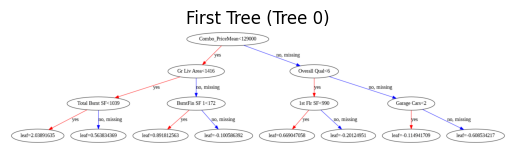

In [64]:
'''Plot first and last tree'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb90_10, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()

In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# dot = to_graphviz(xgb90_10, num_trees=0, rankdir='UT')

# dot.render("xgb90_10_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

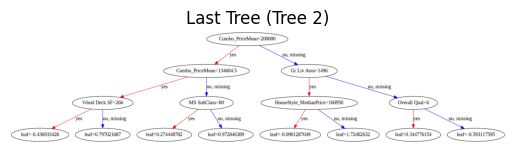

In [ ]:
last_tree_idx = xgb90_10.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb90_10, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [ ]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# dot = to_graphviz(xgb90_10, num_trees=last_tree_idx, rankdir='UT')

# dot.render("xgb90_10_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_lasttree.pdf'

Now using stratified k-fold cv and hyperparameter tuning

First, 20 80 split

In [114]:
'''Split is done to obtain the test set that the model will NOT "see" during the k fold cv'''
# use stratify to preserve class ratios even in the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [115]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [116]:
xgb = XGBClassifier(objective='multi:softmax',
                    num_class=5,
                    eval_metric='mlogloss'
)

Grid Search

In [68]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 0],
    'learning_rate': [00.5, 0.1, 0.2, 0.5],
    'subsample': [0.8, 1.0], # fraction of the training samples (rows) used to grow each tree
    'colsample_bytree': [0.8, 1.0] # fraction of features (columns) used when building each tree
}


In [ ]:
'''DO NOT RUN, TAKES TOO LONG'''

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=parameters,
#     cv=skf,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print(f"Best Mean CV Accuracy: {grid_search.best_score_:.4f}")

Random Search

In [88]:
param_dist = {
    'max_depth': randint(3, 16),          # integer between 3 and 15
    'learning_rate': uniform(0.01, 0.49),  # float between 0.01 and 0.50
    'n_estimators': randint(50, 301),     # integer between 50 and 300
    'subsample': uniform(0.6, 0.4),       # float between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}

In [89]:
random_search = RandomizedSearchCV(
    xgb,
    param_dist,
    cv=skf,
    scoring='accuracy',
    n_iter=10
)


In [90]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.7852575779076212), 'learning_rate': np.float64(0.07640884254040352), 'max_depth': 10, 'n_estimators': 122, 'subsample': np.float64(0.8560609563261534)}


In [91]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [92]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Test Accuracy: 0.7509

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       119
           1       0.62      0.63      0.63       116
           2       0.69      0.65      0.67       116
           3       0.73      0.81      0.77       119
           4       0.90      0.84      0.87       116

    accuracy                           0.75       586
   macro avg       0.75      0.75      0.75       586
weighted avg       0.75      0.75      0.75       586



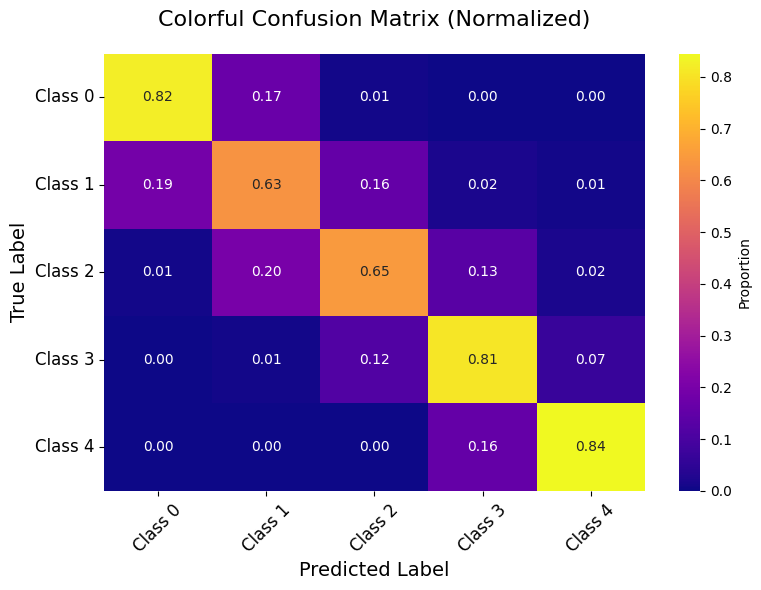

In [93]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

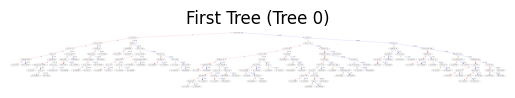

In [94]:
'''Plot trees'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_model, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()


In [95]:
'''Export to pdf'''
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# dot = to_graphviz(best_model, num_trees=0, rankdir='UT')

# dot.render("random_search_xgb_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'random_search_xgb_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

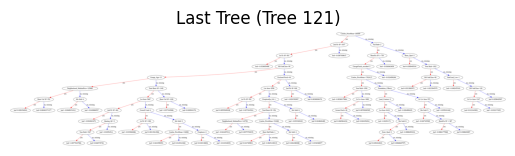

In [96]:
last_tree_idx = best_model.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_model, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [97]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# dot = to_graphviz(best_model, num_trees=last_tree_idx, rankdir='UT')

# dot.render("random_search_xgb_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'random_search_xgb_lasttree.pdf'

Bayesian Optimization

In [129]:
def black_box_function(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    xgb = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softmax',
        num_class=5,
        eval_metric='mlogloss'
    )
    cv_scores = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='accuracy')
    return cv_scores.mean()


In [130]:
'''Set the range for each hyperparameter'''
bounds = {
    'n_estimators': (50, 301),
    'max_depth': (3, 16),
    'learning_rate': (0.01, 0.50),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=bounds,
    random_state=42,

)

In [131]:
optimizer.maximize(init_points=5, n_iter=20)

'''
x = Hyperparameters
f(x) = model’s performance metric, as returned by your evaluation function
      (for example: accuracy, F1, cross-validated score, etc.)
'''
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |
-------------------------------------------------------------------------------------
| 1         | 0.7133672 | 144.00956 | 15.359285 | 0.3686770 | 0.8394633 | 0.6624074 |
| 2         | 0.7099575 | 89.154624 | 3.7550869 | 0.4344263 | 0.8404460 | 0.8832290 |
| 3         | 0.6984227 | 55.166708 | 15.608828 | 0.4178968 | 0.6849356 | 0.6727299 |
| 4         | 0.7069669 | 96.034531 | 6.9551491 | 0.2671306 | 0.7727780 | 0.7164916 |
| 5         | 0.7061150 | 203.57507 | 4.8134201 | 0.1531508 | 0.7465447 | 0.7824279 |
| 6         | 0.7065423 | 152.10021 | 5.9982503 | 0.2027040 | 0.9783245 | 0.9345280 |
| 7         | 0.7197829 | 143.05042 | 15.608620 | 0.0881962 | 0.6440746 | 0.8799912 |
| 8         | 0.7073925 | 142.16235 | 15.017306 | 0.01      | 0.7507845 | 0.6993182 |
| 9         | 0.7035436 | 143.42735 | 15.987285 | 0.0927684 | 0.6       | 1.0       |
| 10        | 0.6988491 | 288.20358 | 15.743398 | 0.30

In [132]:
# extract best params
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_model = XGBClassifier(
    **best_params,
    num_class=5,
    objective='multi:softmax',
    eval_metric='mlogloss'
)
best_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8799912041691051), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.08819629323782344), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None, num_class=5, ...)

In [133]:
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Final Test Accuracy: 0.7372

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       119
           1       0.59      0.59      0.59       116
           2       0.69      0.65      0.67       116
           3       0.73      0.80      0.76       119
           4       0.89      0.84      0.86       116

    accuracy                           0.74       586
   macro avg       0.74      0.74      0.74       586
weighted avg       0.74      0.74      0.74       586



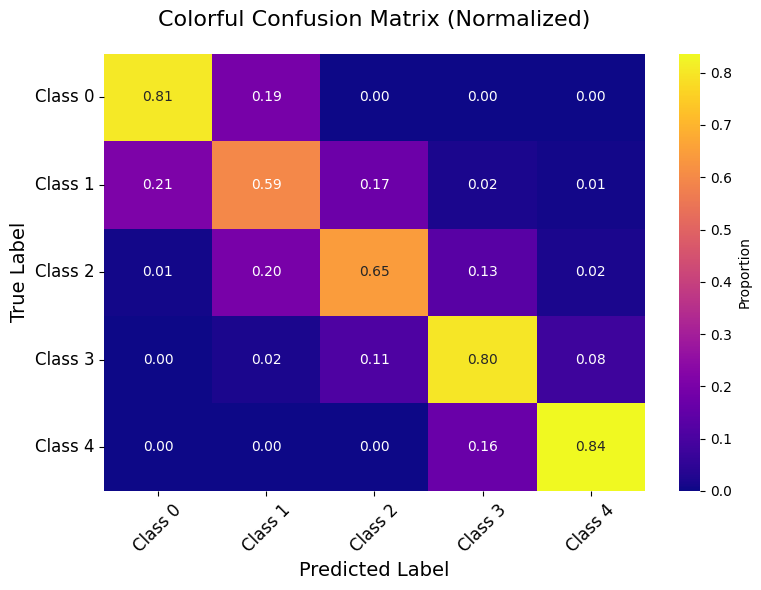

In [134]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


Now 90 10 using stratified k-fold cv and hyperparameter tuning


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [136]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [100]:
xgb = XGBClassifier(objective='multi:softmax',
                    num_class=5,
                    eval_metric='mlogloss')

Grid Search

In [ ]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 0],
    'learning_rate': [00.5, 0.1, 0.2, 0.5],
    'subsample': [0.8, 1.0], # fraction of the training samples (rows) used to grow each tree
    'colsample_bytree': [0.8, 1.0] # fraction of features (columns) used when building each tree
}


In [ ]:
'''DO NOT RUN, TAKES TOO LONG'''

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=parameters,
#     cv=skf,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print(f"Best Mean CV Accuracy: {grid_search.best_score_:.4f}")

Random Search

In [101]:
param_dist = {
    'max_depth': randint(3, 16),          # integer between 3 and 15
    'learning_rate': uniform(0.01, 0.49),  # float between 0.01 and 0.50
    'n_estimators': randint(50, 301),     # integer between 50 and 300
    'subsample': uniform(0.6, 0.4),       # float between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}

In [103]:
random_search = RandomizedSearchCV(
    xgb,
    param_dist,
    cv=skf,
    scoring='accuracy',
    n_iter=10
)

In [104]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print(f"Best Mean CV Accuracy: {random_search.best_score_:.4f}")

Best Parameters: {'colsample_bytree': np.float64(0.6575920195166579), 'learning_rate': np.float64(0.06585314075804333), 'max_depth': 4, 'n_estimators': 250, 'subsample': np.float64(0.8506823621646477)}
Best Mean CV Accuracy: 0.7399


In [105]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [106]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Test Accuracy: 0.7816

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        54
           1       0.69      0.67      0.68        66
           2       0.64      0.70      0.67        54
           3       0.85      0.81      0.83        64
           4       0.92      0.89      0.91        55

    accuracy                           0.78       293
   macro avg       0.79      0.79      0.79       293
weighted avg       0.78      0.78      0.78       293



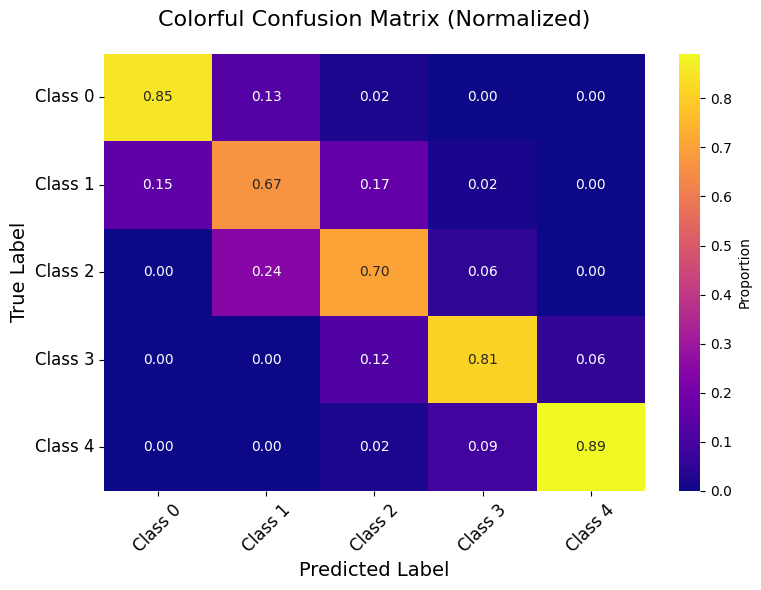

In [107]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

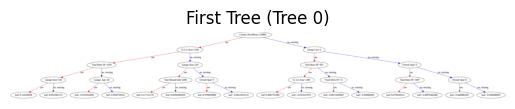

In [108]:
'''Plot trees'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_model, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()


In [109]:
'''Export to pdf'''
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# dot = to_graphviz(best_model, num_trees=0, rankdir='UT')

# dot.render("random_search_xgb9010_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'random_search_xgb9010_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

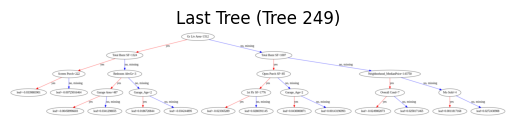

In [110]:
last_tree_idx = best_model.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_model, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [111]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# dot = to_graphviz(best_model, num_trees=last_tree_idx, rankdir='UT')

# dot.render("random_search_xgb9010_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'random_search_xgb9010_lasttree.pdf'

Bayesian Optimization

In [137]:
def black_box_function(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    xgb = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softmax',
        num_class=5,
        eval_metric='mlogloss'
    )
    cv_scores = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='accuracy')
    return cv_scores.mean()



In [138]:
'''Set the range for each hyperparameter'''
bounds = {
    'n_estimators': (50, 301),
    'max_depth': (3, 16),
    'learning_rate': (0.01, 0.50),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=bounds,
    random_state=42
)

In [140]:
optimizer.maximize(init_points=5, n_iter=20)

'''
x = Hyperparameters
f(x) = model’s performance metric, as returned by your evaluation function
      (for example: accuracy, F1, cross-validated score, etc.)
'''
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |
-------------------------------------------------------------------------------------
| 4         | 0.7372709 | 203.57507 | 4.8134201 | 0.1531508 | 0.7465447 | 0.7824279 |
| 5         | 0.7281772 | 247.07916 | 5.5957591 | 0.2619748 | 0.8369658 | 0.6185801 |
| 6         | 0.7262616 | 202.49375 | 5.2168136 | 0.0418752 | 0.9795542 | 0.9862528 |
| 7         | 0.7319766 | 252.90773 | 6.9599789 | 0.0578593 | 0.8736932 | 0.7760609 |
| 8         | 0.7175337 | 80.631596 | 9.4372998 | 0.0268503 | 0.9637281 | 0.7035119 |
| 9         | 0.7209528 | 216.29309 | 7.0522439 | 0.2648333 | 0.8186841 | 0.6739417 |
| 10        | 0.7217277 | 281.39043 | 9.2026869 | 0.4832539 | 0.8911905 | 0.8147276 |
| 11        | 0.7262659 | 203.74023 | 4.9009268 | 0.2712921 | 0.6674226 | 0.9942008 |
| 12        | 0.7300754 | 252.66460 | 6.9549575 | 0.2639685 | 0.7968795 | 0.8735935 |
| 13        | 0.7277969 | 222.08342 | 14.778317 | 0.07

In [141]:
# extract best params
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_model = XGBClassifier(
    **best_params,
    num_class=5,
    objective='multi:softmax',
    eval_metric='mlogloss'
)
best_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7824279936868144), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.1531508777822569), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=203, n_jobs=None, num_class=5, ...)

In [142]:
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Final Test Accuracy: 0.7577

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        54
           1       0.66      0.62      0.64        66
           2       0.63      0.72      0.67        54
           3       0.81      0.80      0.80        64
           4       0.91      0.89      0.90        55

    accuracy                           0.76       293
   macro avg       0.76      0.76      0.76       293
weighted avg       0.76      0.76      0.76       293



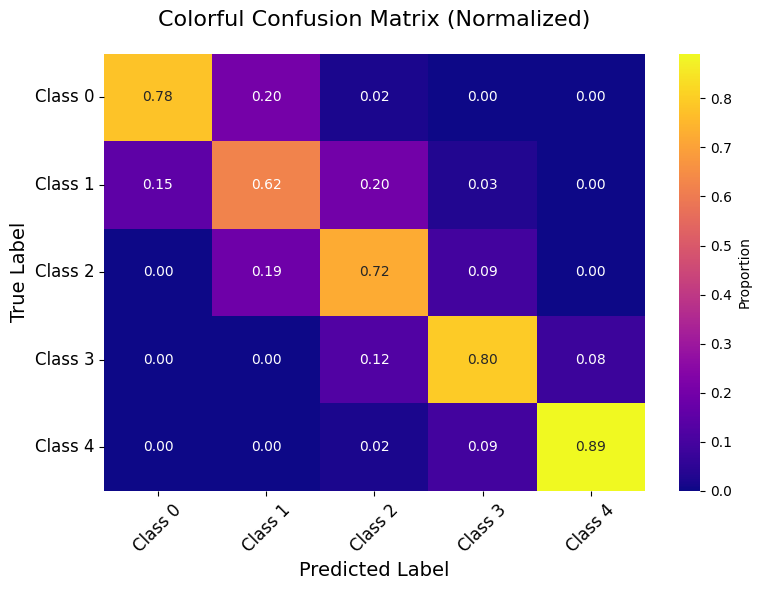

In [143]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()
